# The Hybrid Montecarlo Algorithm

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

In [2]:
%config InlineBackend.figure_format = "retina"
np.seterr(divide='ignore', invalid='ignore')
plt.rcParams["figure.figsize"] = (9, 5)

## A primer on graphing ODEs with python

 * [Source1](https://scipy-cookbook.readthedocs.io/items/LoktaVolterraTutorial.html)
 * [Source2](https://mathinsight.org/introducing_rabbit_predators)

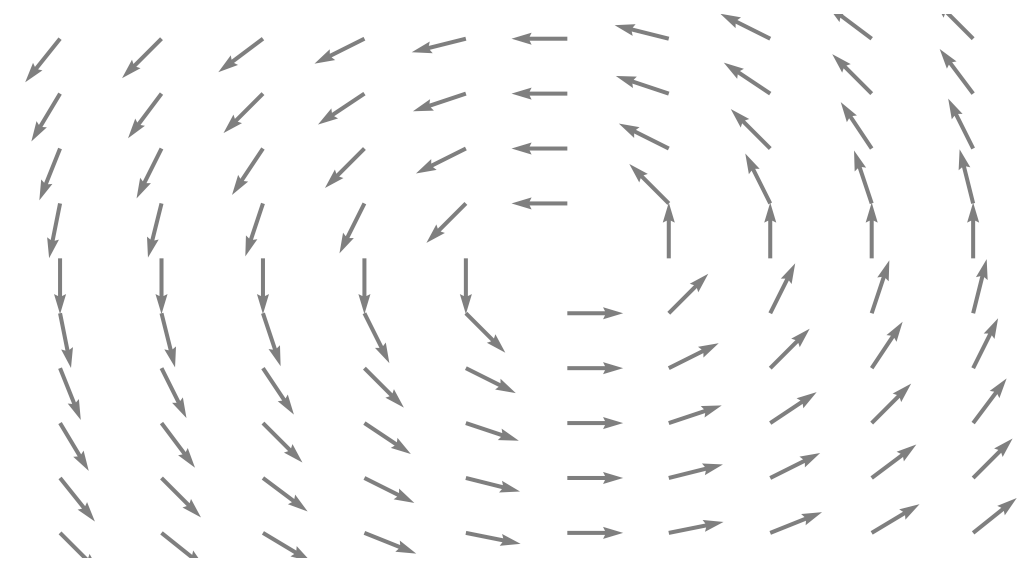

In [3]:
X, Y = np.mgrid[-5:5:1, -5:5:1]
U = - Y / np.sqrt(X ** 2 + Y ** 2)
V =   X / np.sqrt(X ** 2 + Y ** 2)

plt.quiver(X, Y, U, V, color="tab:gray", width=0.004)
plt.axis("off");

### The Lotka-Volterra Model

$$
\begin{align}
\frac{dx}{dt} &= \alpha x - \beta xy\\
\frac{dy}{dt} &= -\gamma y + \delta\beta x y
\end{align}
$$

In [4]:
alpha, beta = 1., 0.1
gamma, delta = 1.5, 0.75

def dX_dt(X, t=0):
    """
    Return growth rate of fox and rabbit populations
    """
    x, y = X
    growth_rate = np.array([
         alpha * x - beta * x * y,
        -gamma * y + delta * beta * x * y
    ])
    return growth_rate

In [5]:
t = np.linspace(0, 15, 1000)
# 10 prays / 5 predators
X0 = np.array([10, 5])
X, infodict = integrate.odeint(dX_dt, X0, t, full_output=True)

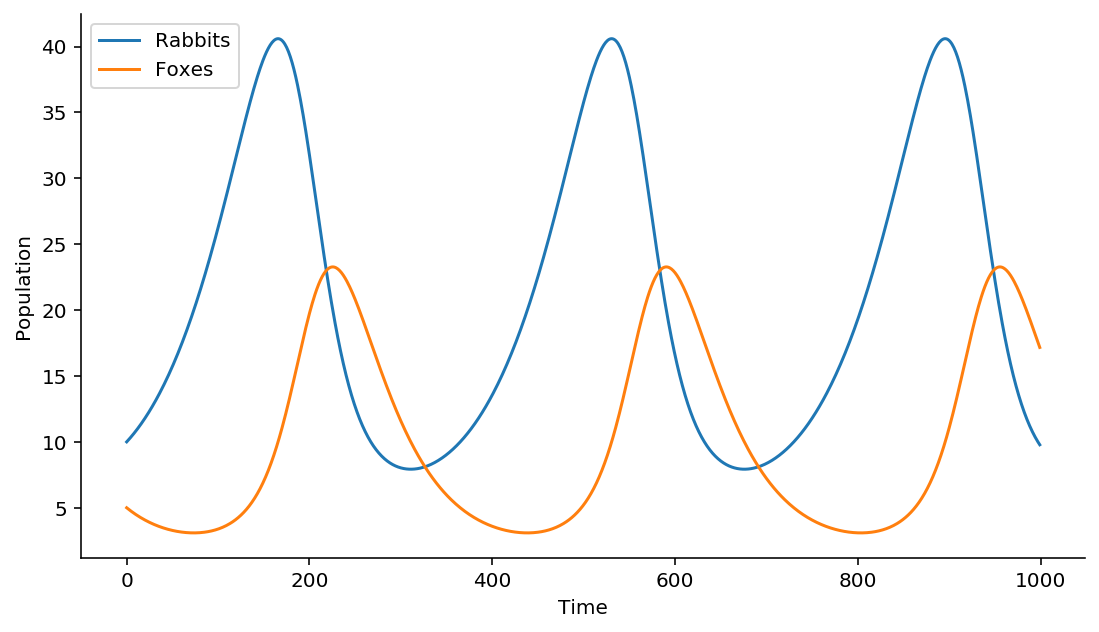

In [6]:
fig, ax = plt.subplots()
ax.plot(X)
ax.legend(["Rabbits", "Foxes"])
ax.set_ylabel("Population")
ax.set_xlabel("Time")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

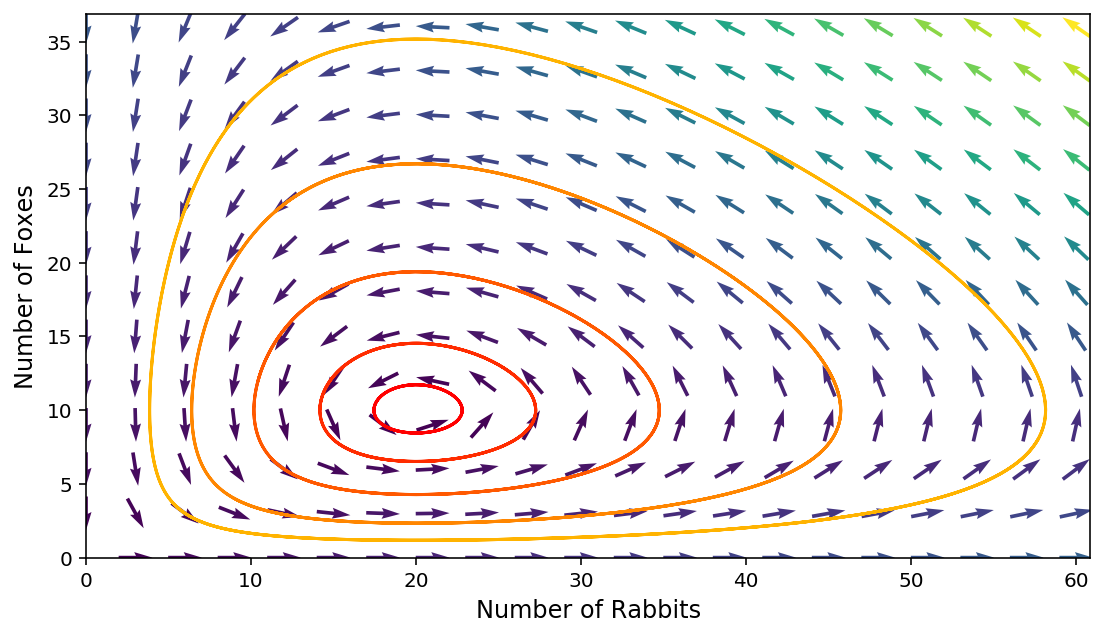

In [7]:
nvals = 5
values = np.linspace(0.3, 0.5, nvals)
vcolors = plt.cm.autumn_r(np.linspace(0.3, 1, nvals))

values = np.array([
    [6, 3],
    [9, 4],
    [12, 6],
    [15, 8],
    [18, 9]
])

for v, col in zip(values, vcolors):
    X0 = v 
    X = integrate.odeint(dX_dt, X0, t)
    plt.plot(*X.T, color=col)
    
ymax = plt.ylim(ymin=0)[1]
xmax = plt.xlim(xmin=0)[1]


step = 3
S = np.mgrid[0:xmax:step, 0:ymax:step]
DS = dX_dt(S)
M = np.hypot(*DS)
DS /= M
    
plt.quiver(*S, *DS, M, pivot="mid")
plt.xlabel("Number of Rabbits", fontsize=12)
plt.ylabel("Number of Foxes", fontsize=12);

## The Hamiltonian

Without loss of generality, we can write the probability distribution $p({\bf z})$ in the form

$$
    p({\bf z}) = \frac{1}{Z_p}\exp\big(-E({\bf z})\big)
$$

where $E({\bf z})$ is the **potential energy** of the system when in state ${\bf z}$.

$$
\begin{align}
    \frac{\text{d}z_i}{\text{d}\tau} &= \frac{\partial H}{\partial r_i}\\
    \frac{\text{d}r_i}{\text{d}\tau} &= -\frac{\partial H}{\partial z_i}
\end{align}
$$

---

$$
\begin{align}
    p(z|\alpha, \beta) &= \frac{\beta^\alpha}{\Gamma(\alpha)}z^{\alpha - 1}\exp(-\beta z)\\
    &= \frac{\beta^\alpha}{\Gamma(\alpha)}\exp\big(({\alpha - 1})\log(z) -\beta z\big)\\
    &= \frac{\beta^\alpha}{\Gamma(\alpha)}\exp\big(-[\beta z -({\alpha - 1})\log(z) ]\big)
\end{align}
$$

In [711]:
sigma2 = 1.5
mu = 0

alpha, beta = 9, 2

def E(z):
    return beta * z - (alpha - 1) * np.log(z)

def dE(z):
    return -(alpha - 1) / z + beta
#     return -(z - mu) / (sigma2)

def dX_dt(X, t=0):
    """
    """
    z, r = X
    growth_rate = np.array([
         r,
        -dE(z)
    ])
    return growth_rate

In [712]:
t = np.linspace(0, 15, 100)
# 10 prays / 5 predators
X0 = np.array([2, 1.5])
X, infodict = integrate.odeint(dX_dt, X0, t, full_output=True)

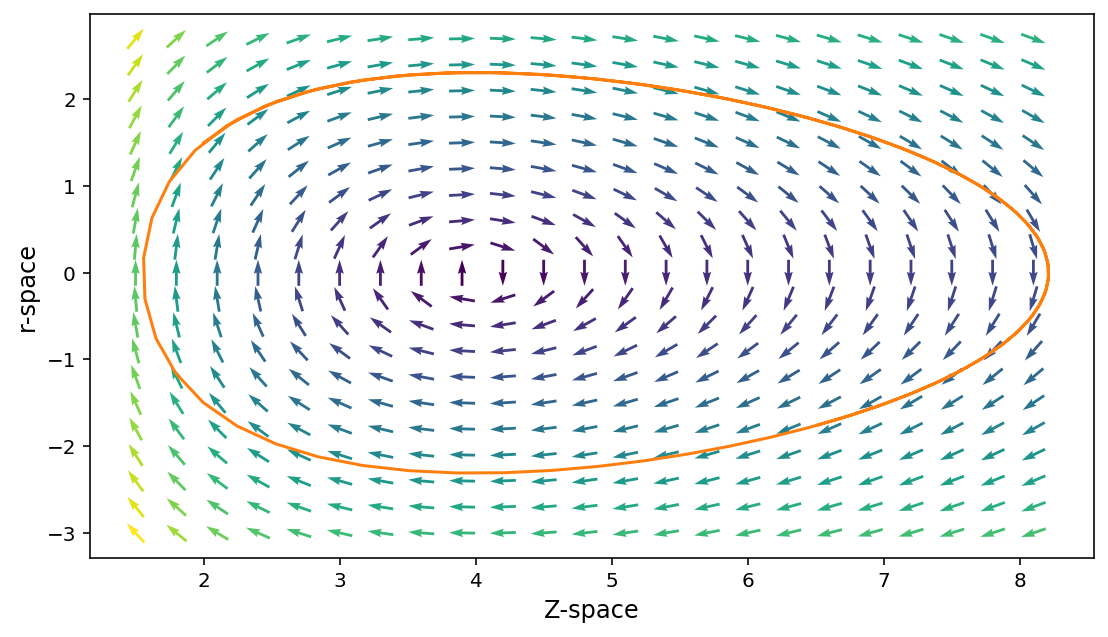

In [713]:
fig, ax = plt.subplots()
xmax = 8.2
ymax = 3

step = 0.3
S = np.mgrid[1.5:xmax:step, -ymax:ymax:step]
DS = dX_dt(S)
M = np.hypot(*DS)
DS /= M
    
ax.quiver(*S, *DS, M, pivot="mid")
ax.set_xlabel("Z-space", fontsize=12)
ax.set_ylabel("r-space", fontsize=12);

ax.plot(*X.T, c="tab:orange");

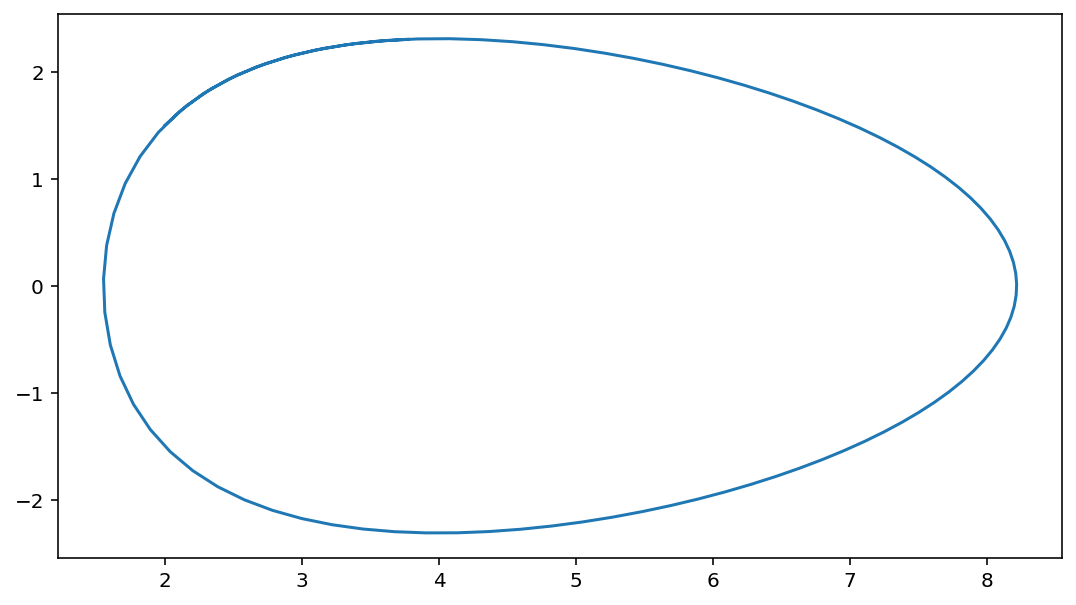

In [714]:
# Simple Leapfro Implementation
z, r = 2, 1.5
eps = 1e-1

steps = [[z, r]]

for _ in range(100):
    r_e2 = r - eps / 2 * dE(z)
    z = z + eps * r_e2
    r = r_e2 - eps / 2 * dE(z)
    steps.append([z, r])
    
steps = np.array(steps)

plt.plot(*steps.T)

In [715]:
def leapfrog(z, r, dE, nsteps=200, eps=1e-3):
    steps = [[z, r]]
    for _ in range(nsteps):
        r_e2 = r - eps / 2 * dE(z)
        z = z + eps * r_e2
        r = r_e2 - eps / 2 * dE(z)
        steps.append([z, r])
    steps = np.array(steps)    
    return steps

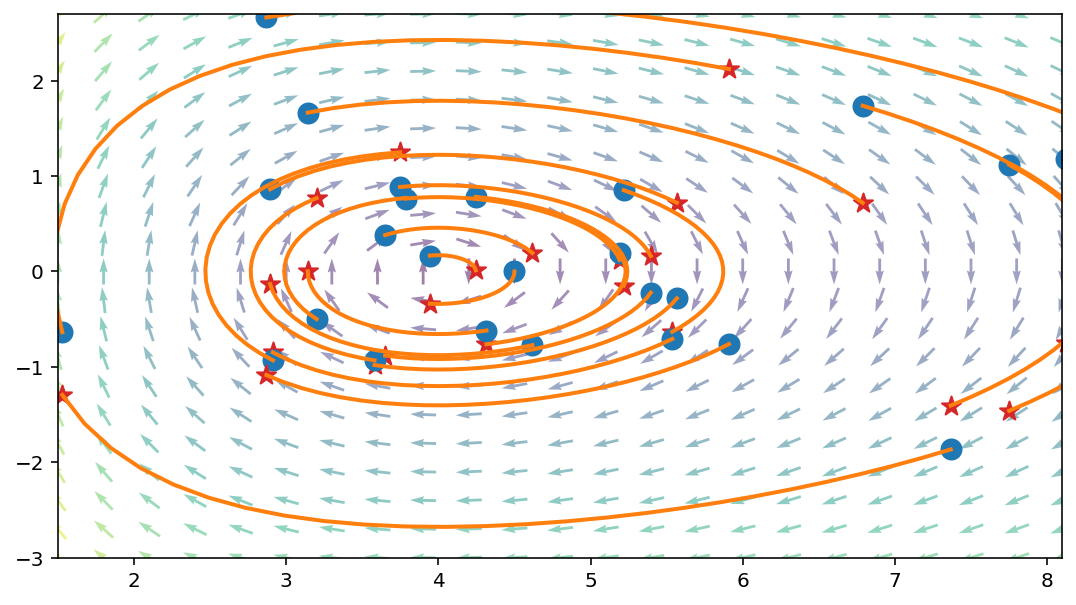

In [721]:
z, r = 4.5, 0
eps = 1e-1

plt.quiver(*S, *DS, M, pivot="mid", alpha=0.5)

all_steps = []
z_obs = []
np.random.seed(314)
for _ in range(25):
    steps = leapfrog(z, r, dE, 25, eps)
    r = np.random.randn()
    z, _ = steps[-1]
    z_obs.append(z)
    all_steps.append(steps)

    plt.scatter(*steps[0], c="tab:blue", s=100, marker="o")
    plt.scatter(*steps[-1], c="tab:red", s=100, marker="*")    
    plt.plot(*steps.T, c="tab:orange", linewidth=2)
    
plt.xlim(S[0].min(), S[0].max())
plt.ylim(S[1].min(), S[1].max());

## The Metropolis Step

* To-Do: Fix backward integration

In [717]:
def H(z, r):
    return E(z) + r ** 2 / 2

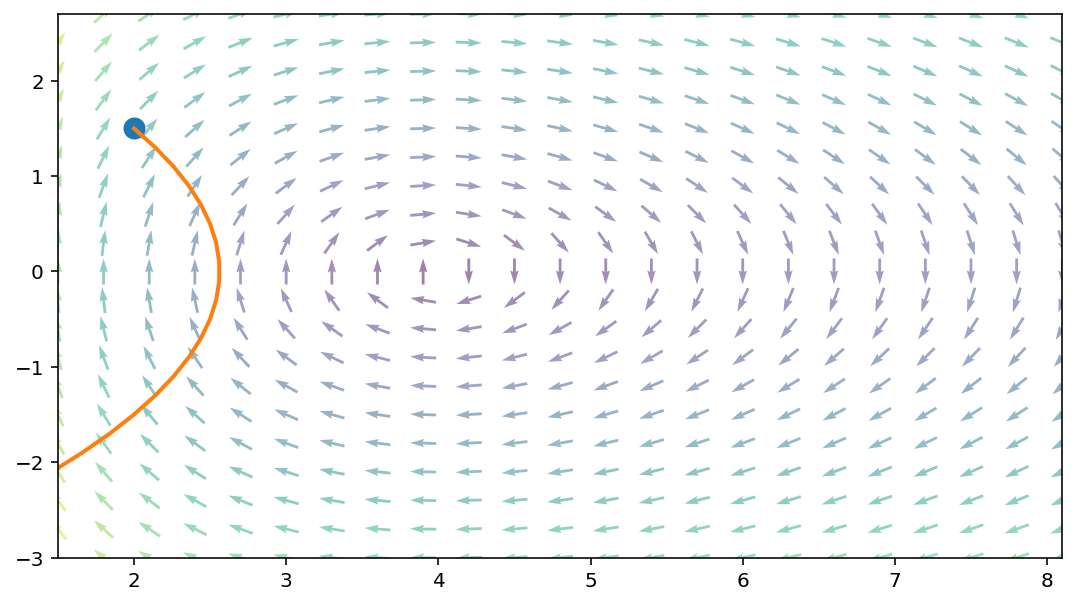

In [710]:
z, r = 2, 1.5
eps = 1e-1

plt.quiver(*S, *DS, M, pivot="mid", alpha=0.5)

all_steps = []
z_obs = []
np.random.seed(314)
for _ in range(25):
    steps = leapfrog(z, r, dE, 25, eps)
    # hmc-metropolis criterion
    m_criterion = min(1, np.exp(H(*steps[0]) - H(*steps[-1])))
    u = np.random.rand()
    
    if m_criterion > -1:
        z, __ = steps[-1]
        z_obs.append(z)
        c_line = "tab:orange"
        alpha = 1
        all_steps.append(steps)
    else:
        c_line = "tab:gray"
        alpha = 0.05
        eps = -eps
    
    r = np.random.randn()
    plt.plot(*steps.T, c=c_line, linewidth=2, alpha=alpha)
    plt.scatter(*steps[0], c="tab:blue", s=100, marker="o")
    plt.scatter(*steps[-1], c="tab:red", s=100, marker="*")
    
plt.xlim(S[0].min(), S[0].max())
plt.ylim(S[1].min(), S[1].max());

## Animating